## Car with Obstacles

In [14]:
using TrajectoryOptimization
using Plots, LinearAlgebra

Import the car model

In [15]:
model = Dynamics.car_model
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [16]:
T = Float64;

Define initial and goals states

In [17]:
x0 = [0.; 0.; 0.]
xf = [1.; 1.; 0.]

3-element Array{Float64,1}:
 1.0
 1.0
 0.0

Define a cost function, e.g., quadratic

In [27]:
Q = (1.0e-2)*Diagonal(I,n)
R = (1.0)*Diagonal(I,m)
Qf = 1000.0*Diagonal(I,n)
cost = LQRCost(Q, R, Qf, xf);

Define obstacles

In [28]:
# create obstacle constraints
r_circle = 0.1
circles = ((0.4,0.25,r_circle),(0.8,0.65,r_circle),(1.0,0.85,r_circle))
n_circles = length(circles)

function circle_obs(c,x,u)
    for i = 1:n_circles
        c[i] = TrajectoryOptimization.circle_constraint(x,circles[i][1],circles[i][2],circles[i][3])
    end
    return nothing
end

obs = Constraint{Inequality}(circle_obs,n,m,n_circles,:obs);

Define a problem

In [29]:
N = 101 # number of knot points
dt = 0.1 # total time

U = [rand(m) for k = 1:N-1] 

obj = Objective(cost,N) # objective with same stagewise costs
constraints = ProblemConstraints([obs],N) # constraints at each stage
    
prob = Problem(model,obj, constraints=constraints, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob,U); # initialize problem with controls

prob_uncon = Problem(model,obj, constraints=constraints, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob_uncon,U); # initialize problem with controls

Solve problem

In [30]:
solve!(prob, ALTROSolverOptions{T}(verbose=true)) # solve with iLQR

Solve unconstrained problem

In [31]:
solve!(prob_uncon, iLQRSolverOptions{T}(verbose=true)) # solve with iLQR

    iter cost          expected    z         α         ρ         dJ        grad      zero_count info                                              
____----------------------------------------------------------------------------------------------------------------------------------------------
    1     8529.2535447  6770.43282  1.025982  0.25      0e+00     6946.34   5.552339 0          
    2     4751.5202035  3731.47463  1.012397  0.25      0e+00     3777.733  1.736937 0          
    3     1114.9940719  3563.61479  1.02046   0.5       0e+00     3636.526  0.894129 0          
    4     274.91053809  836.199164  1.004645  0.5       0e+00     840.0835  0.845753 0          
    5     41.543221436  274.803142  0.849216  1         0e+00     233.3673  0.353762 0          
    6     0.1511349174  41.4803039  0.997873  1         0e+00     41.39209  0.454697 0          
    7     0.0638348064  0.09860646  0.885339  1         0e+00     0.0873    0.172612 0          
    8     0.0516018418  0.0

0.041869111707622336

In [32]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N]

x_uncon = [prob_uncon.X[k][1] for k = 1:N]
y_uncon = [prob_uncon.X[k][2] for k = 1:N];

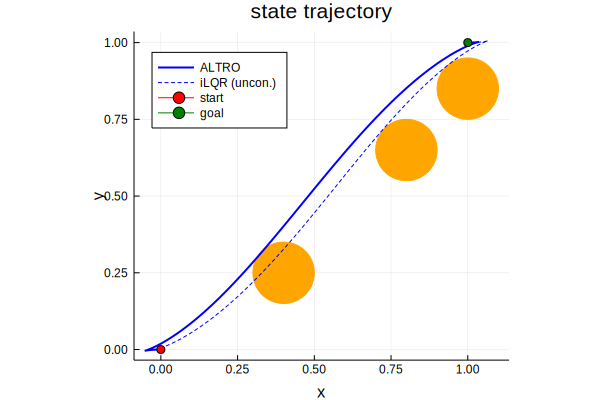

In [33]:
plot()
plot_obstacles(circles,:orange)
plot!(x,y,xlabel="x",ylabel="y",label="ALTRO",legend=:topleft,color=:blue,width=2,ratio=:equal,title="state trajectory")
plot!(x_uncon,y_uncon,xlabel="x",ylabel="y",label="iLQR (uncon.)",legend=:topleft,color=:blue,linestyle=:dash,width=1,ratio=:equal,title="state trajectory")

plot!((x[1],y[1]),marker=:circle,color=:red,label="start")
plot!((x[end],y[end]),marker=:circle,color=:green,label="goal")

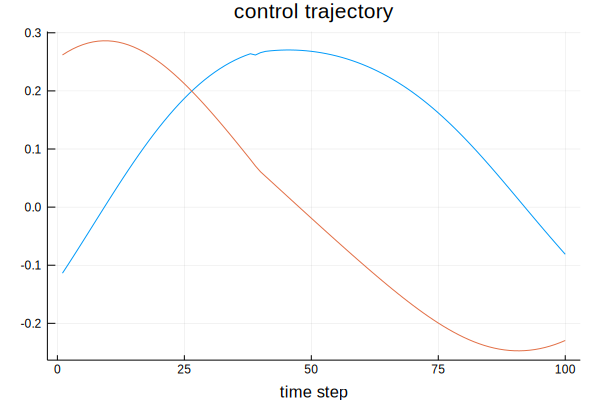

In [34]:
plot(prob.U,xlabel="time step",legend=:none,title="control trajectory")